In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit

plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.labelsize"] = 17
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

In [3]:
@njit("f8[::1](f8[::1],f8)",fastmath=True)
def phase(t_arr,f_test):
    return np.mod(t_arr*f_test,1.0)

@njit("f8(f8[::1],f8[::1],f8,i8)",fastmath=True)
def dispersion(t_arg,m_arg,f_test,bins):
    x = phase(t_arg,f_test)*bins
    ss = np.zeros(bins) # zone variances
    n = np.zeros(bins) # zone occupations
    for i in range(bins):
        mask = (i<=x)&(x<=i+1)
        n[i] = mask.sum()
        if n[i] == 0:
            ss[i] = 0 # empty variance
            n[i] = 1 # cancel Bessel's correction
        else:
            ss[i] = np.var(m_arg[mask])
        
    s2 = ((n-1)@ss)/(n-1).sum() # pooled variance
    return 1-s2/np.var(m_arg)

@njit("f8[:,::1](f8[::1],f8[::1],i8)",fastmath=True)
def hist2d(x_arr,y_arr,bins):
    x = x_arr.copy()*bins
    y = y_arr.copy()*bins
    H = np.zeros((bins,bins))
    for i in range(bins):
        for j in range(bins):
            H[i,j] += sum((i<=x)*(x<=i+1)*(j<=y)*(y<=j+1))
    return H

@njit("f8(f8[::1],f8[::1],f8,i8)",fastmath=True)
def entropy_flattened(t_arg,m_arg,f_test,bins):
    phi = phase(t_arg,f_test)
    rounded_mag = np.empty_like(m_arg)
    np.round(bins*m_arg,0,rounded_mag)
    counts = np.histogram(phi+rounded_mag,bins=bins**2)[0]
    mu = counts/len(t_arg)
    mu = mu[np.nonzero(mu)]
    return -mu@np.log(mu)

@njit("f8(f8[::1],f8[::1],f8,i8)",fastmath=True)
def entropy(t_arg,m_arg,f_test,bins):
    phi = phase(t_arg,f_test)
    H = hist2d(phi,m_arg,bins)
    mu = H.ravel() / len(phi)
    mu = mu[np.nonzero(mu)]
    return -mu@np.log(mu)

@njit("f8(f8[::1],f8[::1],f8)",fastmath=True)
def arclength(t_arg,m_arg,f_test):
    phi = phase(t_arg,f_test)
    index = phi.argsort()
    return sum(np.diff(phi[index])**2 + np.diff(m_arg[index])**2) + \
        (phi[0]-phi[-1]-1)**2 + (m_arg[0]-m_arg[-1])**2

@njit("f8(f8[::1],f8[::1],f8)",fastmath=True)
def lombscargle(t_arg,m_arg,f_test):
    ωt = f_test*2*np.pi*t_arg
    c = np.cos(ωt)
    s = np.sin(ωt)
    mc = sum(m_arg*c)
    ms = sum(m_arg*s)
    cc = sum(c**2)
    ss = sum(s**2)
    cs = sum(c*s)
    ωτ = np.arctan(2*cs/(cc-ss))/2
    cτ = np.cos(ωτ)
    sτ = np.sin(ωτ)
    P = 1/2 * (
        (cτ*mc+sτ*ms)**2/(cτ**2*cc+2*cτ*sτ*cs+sτ**2*ss) + 
        (cτ*ms-sτ*mc)**2/(cτ**2*ss+2*cτ*sτ*cs+sτ**2*cc)
    )
    return P

@njit("f8(f8[::1],f8[::1],f8)",fastmath=True)
def fourier(t_arg,m_arg,f_test):
    return abs(sum((m_arg-m_arg.mean()) * np.exp(-2j*np.pi*t_arg*f_test)))**2

@njit("f8[::1](f8[::1],f8[::1],f8,f8,f8)",fastmath=True)
def fourier_incremental(t_arg,m_arg,f_ini,f_end,df):
    dF = np.exp(-2j*np.pi*t_arg*df)
    F = np.zeros_like(np.arange(f_ini,f_end,df))
    curl = m_arg * np.exp(-2j*np.pi*t_arg*f_ini)
    F[0] = np.abs(sum(curl))
    for i in range(1,len(F)):
        curl = curl*dF
        F[i] = np.abs(sum(curl))**2
    return F

######

@njit("f8[::1](f8[::1],f8[::1],f8[::1],i8)",fastmath=True)
def dispersion_periodogram(t_arg,m_arg,f_arg,bins):
    P = np.zeros_like(f_arg)
    for i in range(len(P)):
        P[i] = dispersion(t_arg,m_arg,f_arg[i],bins)
    return P

@njit("f8[::1](f8[::1],f8[::1],f8[::1],i8)",fastmath=True)
def entropy_periodogram(t_arg,m_arg,f_arg,bins):
    P = np.zeros_like(f_arg)
    for i in range(len(P)):
        P[i] = entropy(t_arg,m_arg,f_arg[i],bins)
    return P

@njit("f8[::1](f8[::1],f8[::1],f8[::1],i8)",fastmath=True)
def entropy_flattened_periodogram(t_arg,m_arg,f_arg,bins):
    P = np.zeros_like(f_arg)
    for i in range(len(P)):
        P[i] = entropy_flattened(t_arg,m_arg,f_arg[i],bins)
    return P

@njit("f8[::1](f8[::1],f8[::1],f8[::1])",fastmath=True)
def arclength_periodogram(t_arg,m_arg,f_arg):
    P = np.zeros_like(f_arg)
    for i in range(len(P)):
        P[i] = arclength(t_arg,m_arg,f_arg[i])
    return P

@njit("f8[::1](f8[::1],f8[::1],f8[::1])",fastmath=True)
def fourier_periodogram(t_arg,m_arg,f_arg):
    P = np.zeros_like(f_arg)
    for i in range(len(P)):
        P[i] = fourier(t_arg,m_arg,f_arg[i])
    return P

@njit("f8[::1](f8[::1],f8[::1],f8[::1])",fastmath=True)
def lombscargle_periodogram(t_arg,m_arg,f_arg):
    P = np.zeros_like(f_arg)
    for i in range(len(P)):
        P[i] = lombscargle(t_arg,m_arg,f_arg[i])
    return P

In [5]:
def normalize(arr):
    return (arr-arr.min())/arr.ptp()

## Single

In [4]:
t,mag,err = np.loadtxt("OGLE-LMC-CEP-0002.dat",unpack=True)
m = normalize(mag)
t = np.ascontiguousarray(t)
m = np.ascontiguousarray(m)
freq = 1/3.1181490

In [435]:
%timeit -n10000 -r10 arclength(t,m,freq)
%timeit -n10000 -r10 entropy(t,m,freq,5)
%timeit -n10000 -r10 entropy_flattened(t,m,freq,5)
%timeit -n10000 -r10 dispersion(t,m,freq,5) 
%timeit -n10000 -r10 lombscargle(t,m,freq)
%timeit -n10000 -r10 fourier(t,m,freq)

29.8 µs ± 1.22 µs per loop (mean ± std. dev. of 10 runs, 10000 loops each)
43 µs ± 554 ns per loop (mean ± std. dev. of 10 runs, 10000 loops each)
18.3 µs ± 383 ns per loop (mean ± std. dev. of 10 runs, 10000 loops each)
24.3 µs ± 541 ns per loop (mean ± std. dev. of 10 runs, 10000 loops each)
21.5 µs ± 809 ns per loop (mean ± std. dev. of 10 runs, 10000 loops each)
13.7 µs ± 634 ns per loop (mean ± std. dev. of 10 runs, 10000 loops each)


## Periodogram

In [5]:
f_min = 0.1
f_max = 1.5
df = 0.0001
fs = np.arange(f_min,f_max,df)
len(fs)

14000

In [441]:
%timeit -n1 -r10 arclength_periodogram(t,m,fs)
%timeit -n1 -r10 entropy_periodogram(t,m,fs,5)
%timeit -n1 -r10 entropy_flattened_periodogram(t,m,fs,5)
%timeit -n1 -r10 dispersion_periodogram(t,m,fs,5) 
%timeit -n1 -r10 lombscargle_periodogram(t,m,fs)
%timeit -n1 -r10 fourier_periodogram(t,m,fs)
%timeit -n1 -r10 fourier_incremental(t,m,f_min,f_max,df)

729 ms ± 9.31 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
738 ms ± 4.38 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
397 ms ± 4.07 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
497 ms ± 3.82 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
353 ms ± 3.76 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
233 ms ± 8.24 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
16.8 ms ± 304 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [33]:
from scipy.signal import lombscargle as scipy_LS
%timeit -n10 -r10 scipy_LS(t,m,2*np.pi*fs)

30.6 ms ± 744 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


## Plot

In [6]:
ts,dts = np.array([
[29.8, 1.22],
[43.0, 0.554],
[18.3, 0.383],
[24.3, 0.541],
[21.5, 0.809],
[13.7, 0.634],
]).T

Ts,dTs = np.array([
[729,9.31],
[738,4.38],
[397,4.07],
[497,3.82],
[353,3.76],
[233,8.24],
[16.8,0.304],
]).T

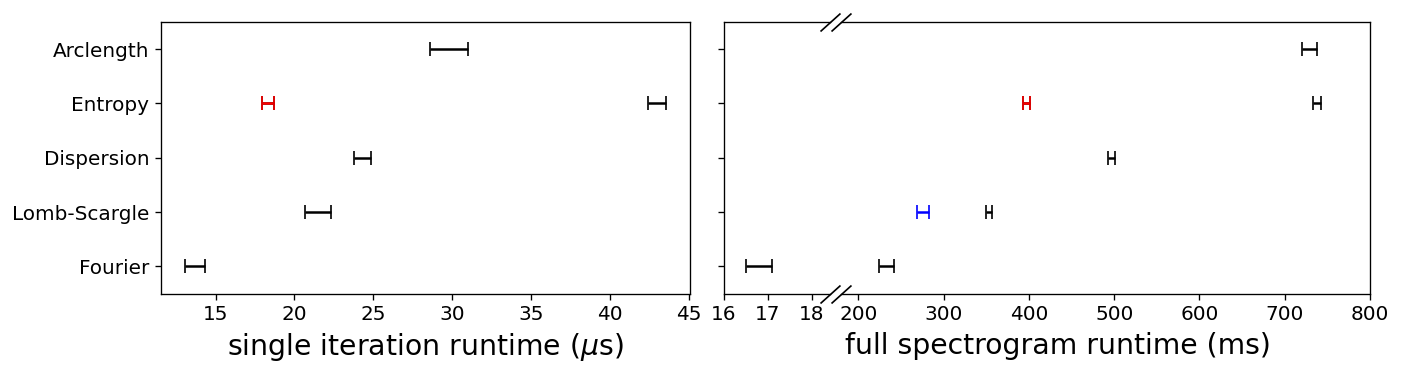

In [13]:
fig,ax = plt.subplots(ncols=4,figsize=(13,3),gridspec_kw={'width_ratios':[1,0.02,0.2,1],'wspace':0.04})

ax[2].spines['right'].set_visible(False)
ax[3].spines['left'].set_visible(False)

plt.sca(ax[2])
plt.errorbar(Ts[-1],[1],xerr=dTs[-1],fmt=" ",color='k',capsize=4)
plt.xlim(16,18.4)
plt.xticks([16,17,18])
plt.yticks([1,2,3,4,5],[""]*5)
plt.ylim(0.5,5.5)

plt.sca(ax[3])
plt.errorbar(Ts,[5,4,4,3,2,1,1],xerr=dTs,fmt=" ",color='k',capsize=4)
plt.errorbar(Ts[2],[4],xerr=dTs[2],fmt=" ",color='r',capsize=4)
plt.errorbar([276],[2],xerr=6.87,fmt=" ",color='b',capsize=4)
#plt.xlabel("full spectrogram runtime (ms)")
plt.xlim(180,800)
plt.xticks(np.arange(200,801,100))
plt.ylim(0.5,5.5)
plt.yticks([])

d = 0.9  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[2].plot([1, 1], [0, 1], transform=ax[2].transAxes, **kwargs)
ax[3].plot([0, 0], [0, 1], transform=ax[3].transAxes, **kwargs)
#ax[2].plot([1, 0], [0, 1], transform=ax[2].transAxes, **kwargs)


plt.sca(ax[0])
plt.errorbar(ts,[5,4,4,3,2,1],xerr=dts,fmt=" ",color='k',capsize=4)
plt.errorbar(ts[2],[4],xerr=dts[2],fmt=" ",color='r',capsize=4)
plt.xlabel("single iteration runtime ($\\mu$s)")
plt.yticks([1,2,3,4,5],["Fourier","Lomb-Scargle","Dispersion","Entropy","Arclength"]);
plt.ylim(0.5,5.5)

ax[1].set_visible(False)
fig.text(0.7, -0.02, 'full spectrogram runtime (ms)', va='center', ha='center', fontsize=plt.rcParams['axes.labelsize'])

plt.savefig("../../text/img/runtimes.pdf",bbox_inches='tight')

## Specs plot

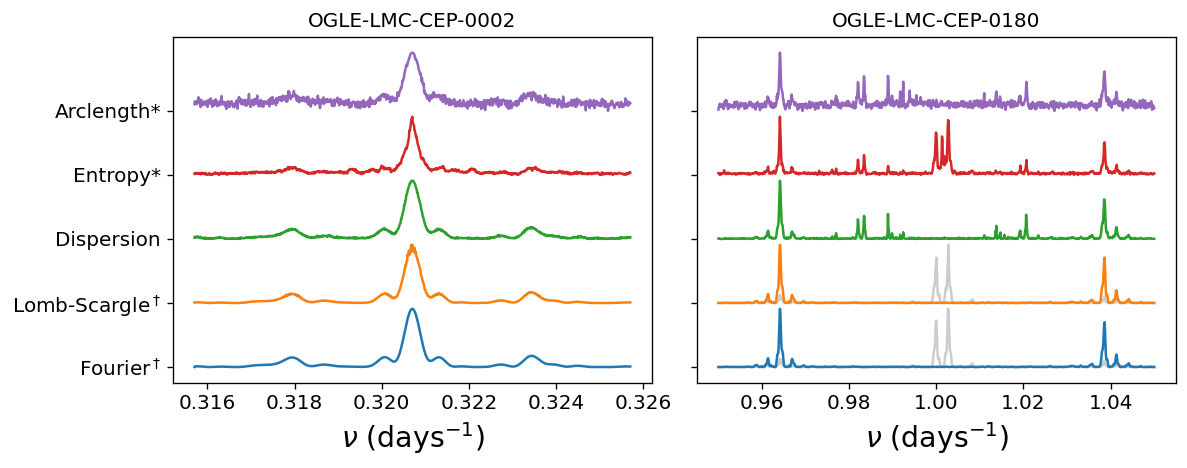

In [8]:
fig,ax = plt.subplots(ncols=2,figsize=(10,4),sharey=True)

t,mag,err = np.loadtxt("OGLE-LMC-CEP-0002.dat",unpack=True)
m = normalize(mag)
t = np.ascontiguousarray(t)
m = np.ascontiguousarray(m)
freq = 1/3.1181490

f_min = freq-0.005
f_max = freq+0.005
df = 0.00001
fs = np.arange(f_min,f_max,df)

F = fourier_incremental(t,m-0.5,f_min,f_max,df)
LS = lombscargle_periodogram(t,m-0.5,fs)
D = dispersion_periodogram(t,m,fs,10)
E = entropy_flattened_periodogram(t,m,fs,10)
A = arclength_periodogram(t,m,fs)

plt.sca(ax[0])
plt.title("OGLE-LMC-CEP-0002")
plt.plot(fs,normalize(F))
plt.plot(fs,normalize(LS)+1.1)
plt.plot(fs,normalize(D)+2.2)
plt.plot(fs,1-normalize(E)+3.3)
plt.plot(fs,1-normalize(A)+4.4)
plt.xlabel(r"$\nu$ (days${}^{-1}$)")

plt.yticks([0,1.1,2.2,3.3,4.4],["Fourier${}^\dagger$","Lomb-Scargle${}^\dagger$","Dispersion","Entropy*","Arclength*"]);


t,mag,err = np.loadtxt("OGLE-LMC-CEP-0180.dat",unpack=True)
m = normalize(mag)
t = np.ascontiguousarray(t)
m = np.ascontiguousarray(m)

f_min = 0.95
f_max = 1.05
df = 0.0001
fs = np.arange(f_min,f_max,df)

F_raw = fourier_incremental(t,m,f_min,f_max,df)
F = fourier_incremental(t,m-m.mean(),f_min,f_max,df)
LS_raw = lombscargle_periodogram(t,m,fs)
LS = lombscargle_periodogram(t,m-m.mean(),fs)
D = dispersion_periodogram(t,m,fs,6)
E = entropy_flattened_periodogram(t,m,fs,6)
A = arclength_periodogram(t,m,fs)

plt.sca(ax[1])
plt.title("OGLE-LMC-CEP-0180")
plt.plot(fs,normalize(F_raw),c='k',alpha=0.2)
plt.plot(fs,normalize(F))
plt.plot(fs,normalize(LS_raw)+1.1,c='k',alpha=0.2)
plt.plot(fs,normalize(LS)+1.1)
plt.plot(fs,normalize(D)+2.2)
plt.plot(fs,1-normalize(E)+3.3)
plt.plot(fs,1-normalize(A)+4.4)
plt.xlabel(r"$\nu$ (days${}^{-1}$)")

plt.tight_layout()
plt.savefig("../../text/img/examples.pdf")

## Problem plot

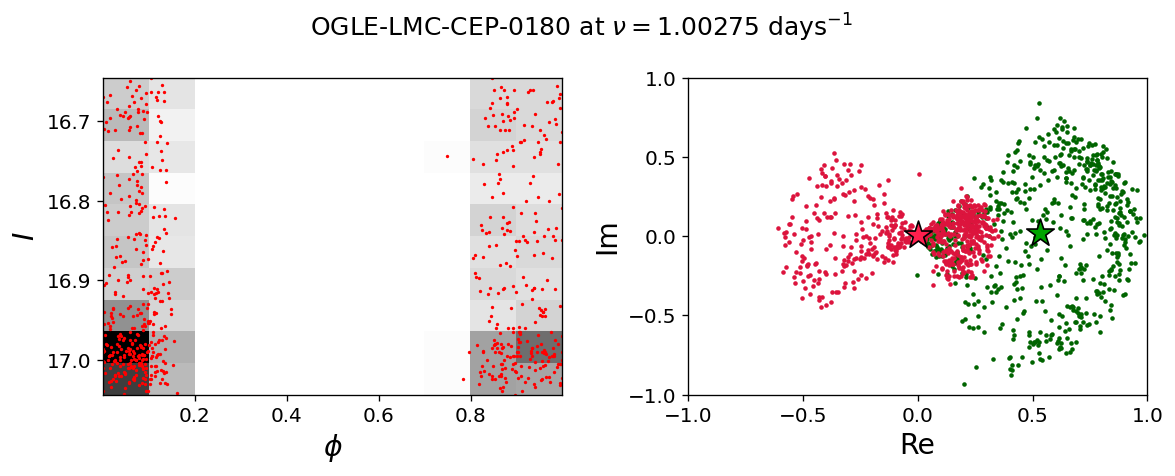

In [9]:
t,mag,err = np.loadtxt("OGLE-LMC-CEP-0180.dat",unpack=True)
m = normalize(mag)
t = np.ascontiguousarray(t)
m = np.ascontiguousarray(m)

f_min = 0.99
f_max = 1.01
df = 0.00005
fs = np.arange(f_min,f_max,df)
E = entropy_periodogram(t,m,fs,10)

freq = fs[E.argmin()]
phi = phase(t,freq)

F = m*np.exp(2j*np.pi*freq*t)
F2 = (m-m.mean())*np.exp(2j*np.pi*freq*t)

fig,ax = plt.subplots(ncols=2,figsize=(10,4))

plt.sca(ax[0])
plt.hist2d(phi,mag,cmap='binary',bins=10)
plt.scatter(phi[phi.argsort()],mag[phi.argsort()],color='r',s=1)
plt.ylim(np.flip(plt.gca().get_ylim()))
plt.ylabel("$I$")
plt.xlabel("$\\phi$")

plt.sca(ax[1])
plt.scatter(F.real,F.imag,s=3,color="#006400")
plt.scatter(F.real.mean(),F.imag.mean(),color="#00a400",marker="*",s=300,edgecolors='k')

plt.scatter(F2.real,F2.imag,s=3,color="#dc143d")
plt.scatter(F2.real.mean(),F2.imag.mean(),color="#ff204e",marker="*",s=300,edgecolors='k')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.ylabel("Im")
plt.xlabel("Re")

plt.suptitle(fr"OGLE-LMC-CEP-0180 at $\nu={freq:.5f}$ days${{}}^{{-1}}$",fontsize=15)
plt.tight_layout()
plt.savefig("../../text/img/alias.pdf")

## Entropy comparison

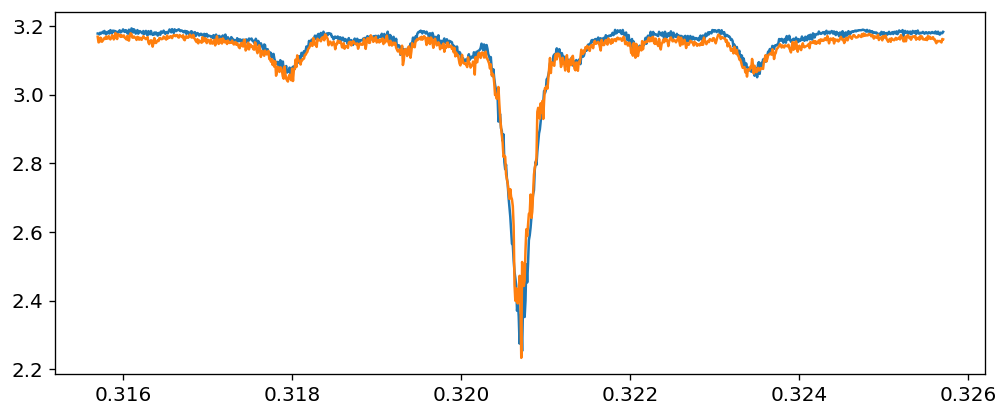

In [12]:
plt.figure(figsize=(10,4))
t,mag,err = np.loadtxt("OGLE-LMC-CEP-0002.dat",unpack=True)
m = normalize(mag)
t = np.ascontiguousarray(t)
m = np.ascontiguousarray(m)
freq = 1/3.1181490

f_min = freq-0.005
f_max = freq+0.005
df = 0.00001
fs = np.arange(f_min,f_max,df)
plt.plot(fs,[entropy(t,m,f,5) for f in fs])
plt.plot(fs,[entropy_flattened(t,m,f,5) for f in fs])

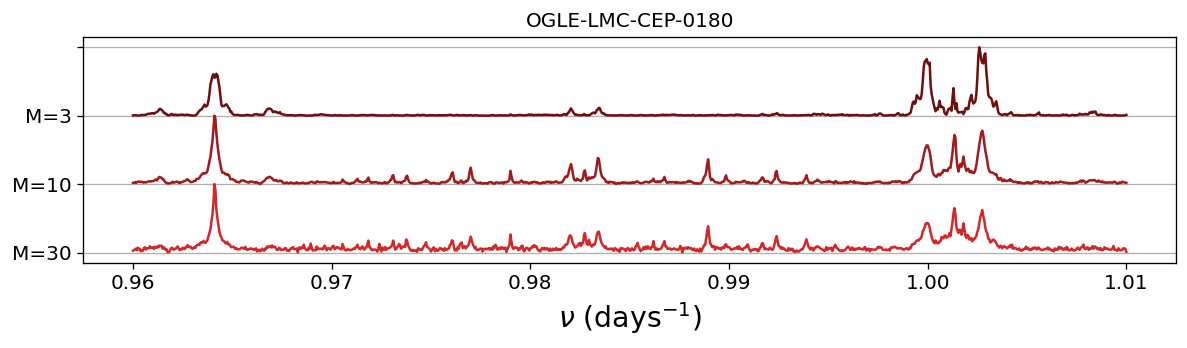

In [31]:
t,mag,err = np.loadtxt("OGLE-LMC-CEP-0180.dat",unpack=True)
m = normalize(mag)
t = np.ascontiguousarray(t)
m = np.ascontiguousarray(m)

f_min = 0.96
f_max = 1.01
df = 0.00005
fs = np.arange(f_min,f_max,df)

plt.figure(figsize=(10,3))
plt.plot(fs,2-normalize(np.array([entropy(t,m,f,3) for f in fs])),c='#6f0f0f')
plt.plot(fs,1-normalize(np.array([entropy(t,m,f,10) for f in fs])),c='#a11b1c')
plt.plot(fs,-normalize(np.array([entropy(t,m,f,30) for f in fs])),c='#d62728')
plt.yticks([2,1,0,-1],["","M=3","M=10","M=30"])
plt.grid(axis='y')
plt.xlabel(r"$\nu$ (days${}^{-1}$)")
plt.title("OGLE-LMC-CEP-0180")

plt.tight_layout()
plt.savefig("../../text/img/entropy_bins.pdf")

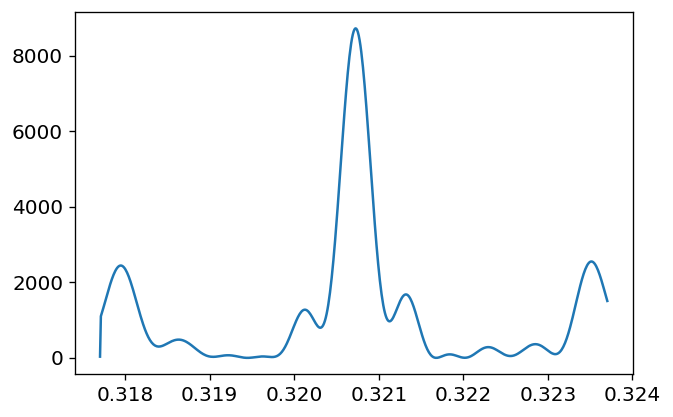

In [46]:
t,mag,err = np.loadtxt("OGLE-LMC-CEP-0002.dat",unpack=True)
m = normalize(mag)
t = np.ascontiguousarray(t)
m = np.ascontiguousarray(m)
freq = 1/3.1181490

f_min = freq-0.003
f_max = freq+0.003
df = 0.00001
fs = np.arange(f_min,f_max,df)
plt.plot(fs,fourier_incremental(t,m,f_min,f_max,df))

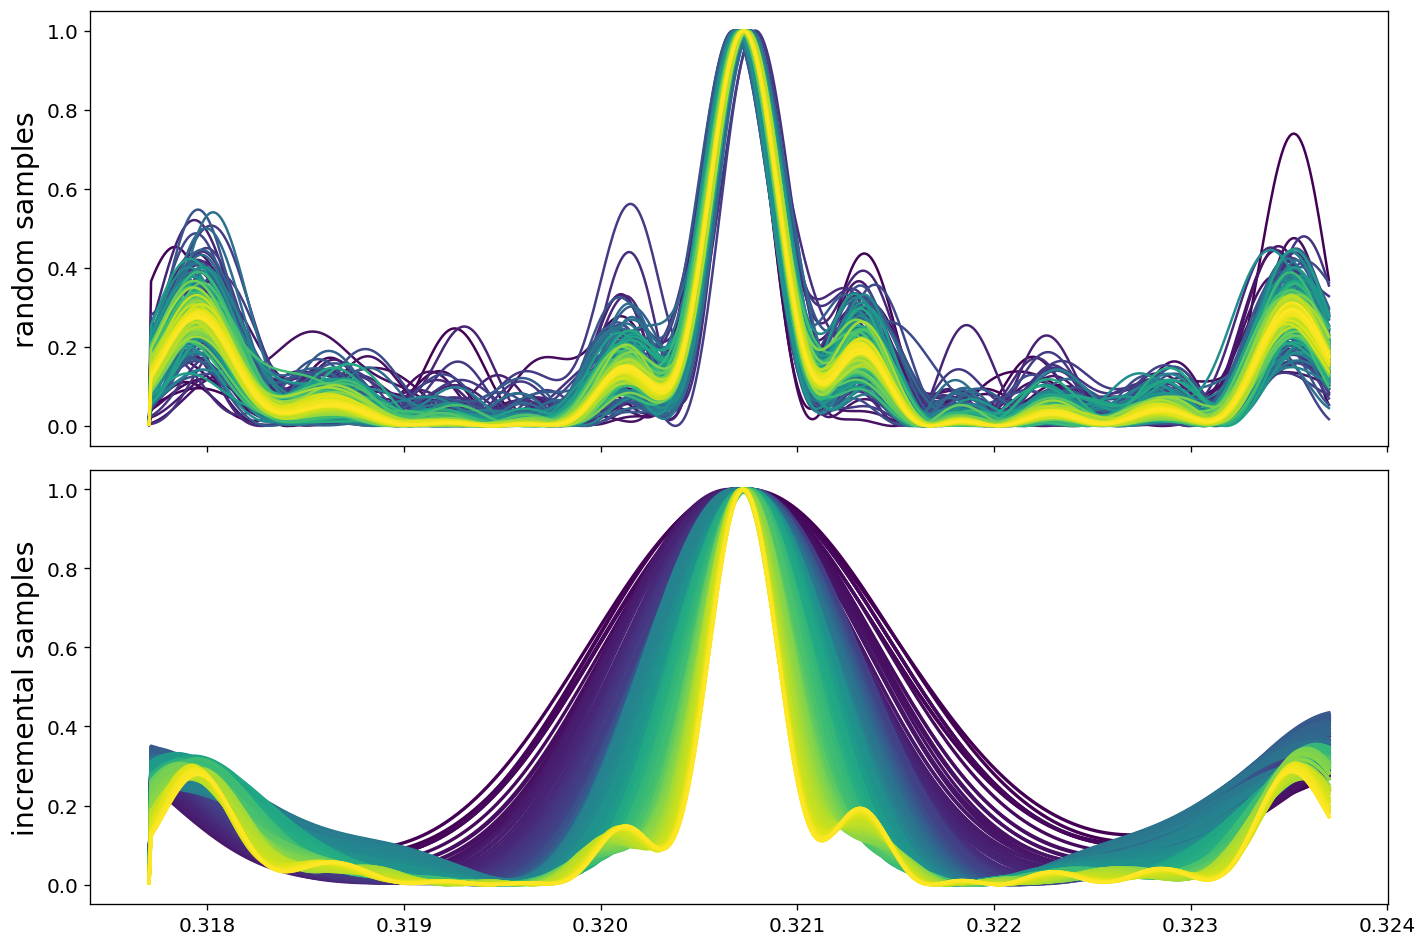

In [69]:
cmap = plt.get_cmap()
imin,imax,di = (150,len(t),1)

fig,ax = plt.subplots(nrows=2,figsize=(12,8),sharex=True)

plt.sca(ax[0])

for i in range(imin,imax,di):
    mask = np.random.choice(np.arange(len(t)),i,False)
    t_ = np.ascontiguousarray(t[mask])
    m_ = np.ascontiguousarray(m[mask])
    color_index = (i-imin)/(imax-imin)
    F = fourier_incremental(t_,m_,f_min,f_max,df)
    F /= F.max()
    plt.plot(fs,F,c=cmap(color_index))
plt.ylabel("random samples")
    
plt.sca(ax[1])
    
for i in range(imin,imax,di):
    t_ = np.ascontiguousarray(t[:i])
    m_ = np.ascontiguousarray(m[:i])
    color_index = (i-imin)/(imax-imin)
    F = fourier_incremental(t_,m_,f_min,f_max,df)
    F /= F.max()
    plt.plot(fs,F,c=cmap(color_index),linewidth=2)
plt.ylabel("incremental samples")

plt.tight_layout()

## I and V

CPU times: user 30.8 ms, sys: 91 µs, total: 30.9 ms
Wall time: 70.1 ms


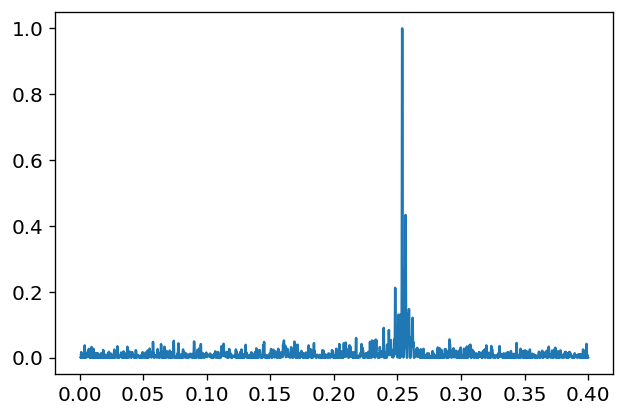

In [41]:
%%time
f_min, f_max, df = 0.001,0.4,5e-5
fs = np.arange(f_min,f_max,df)

t,mag,err = np.loadtxt("../../../data/ogle4/OCVS/lmc/cep/phot/I/OGLE-LMC-CEP-0001.dat",unpack=True)
t = np.ascontiguousarray(t)
m = np.ascontiguousarray(mag) - mag.mean()

F = fourier_incremental(t,m,f_min,f_max,df)
plt.plot(fs,F/F.max())

In [247]:
np.ptp(mag1)

0.28699999999999903

In [290]:
np.std(np.mean(np.random.choice(mag,(len(mag),len(mag))),axis=1))

0.004175374059273878

In [288]:
1/np.sqrt(sum(1/err**2))

0.000253861949817559

0.005

(0.32, 0.322)

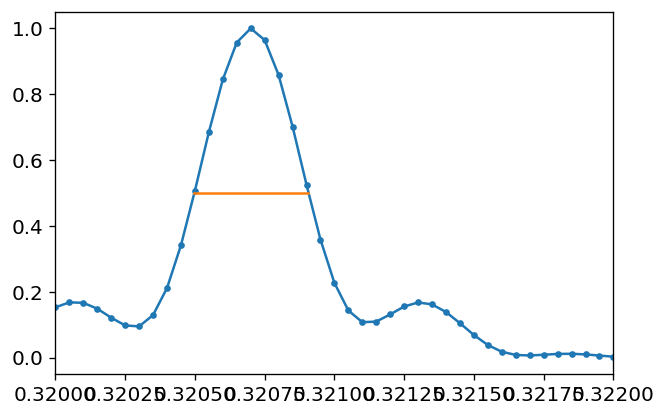

In [240]:
plt.plot(fs,F/F.max(),".-")
freq = fs[F.argmax()]
sigma_freq = df*props['widths'][props['peak_heights'].argmax()]/2
plt.plot([freq-sigma_freq,freq+sigma_freq],[0.5,0.5])
plt.xlim(0.32,0.322)

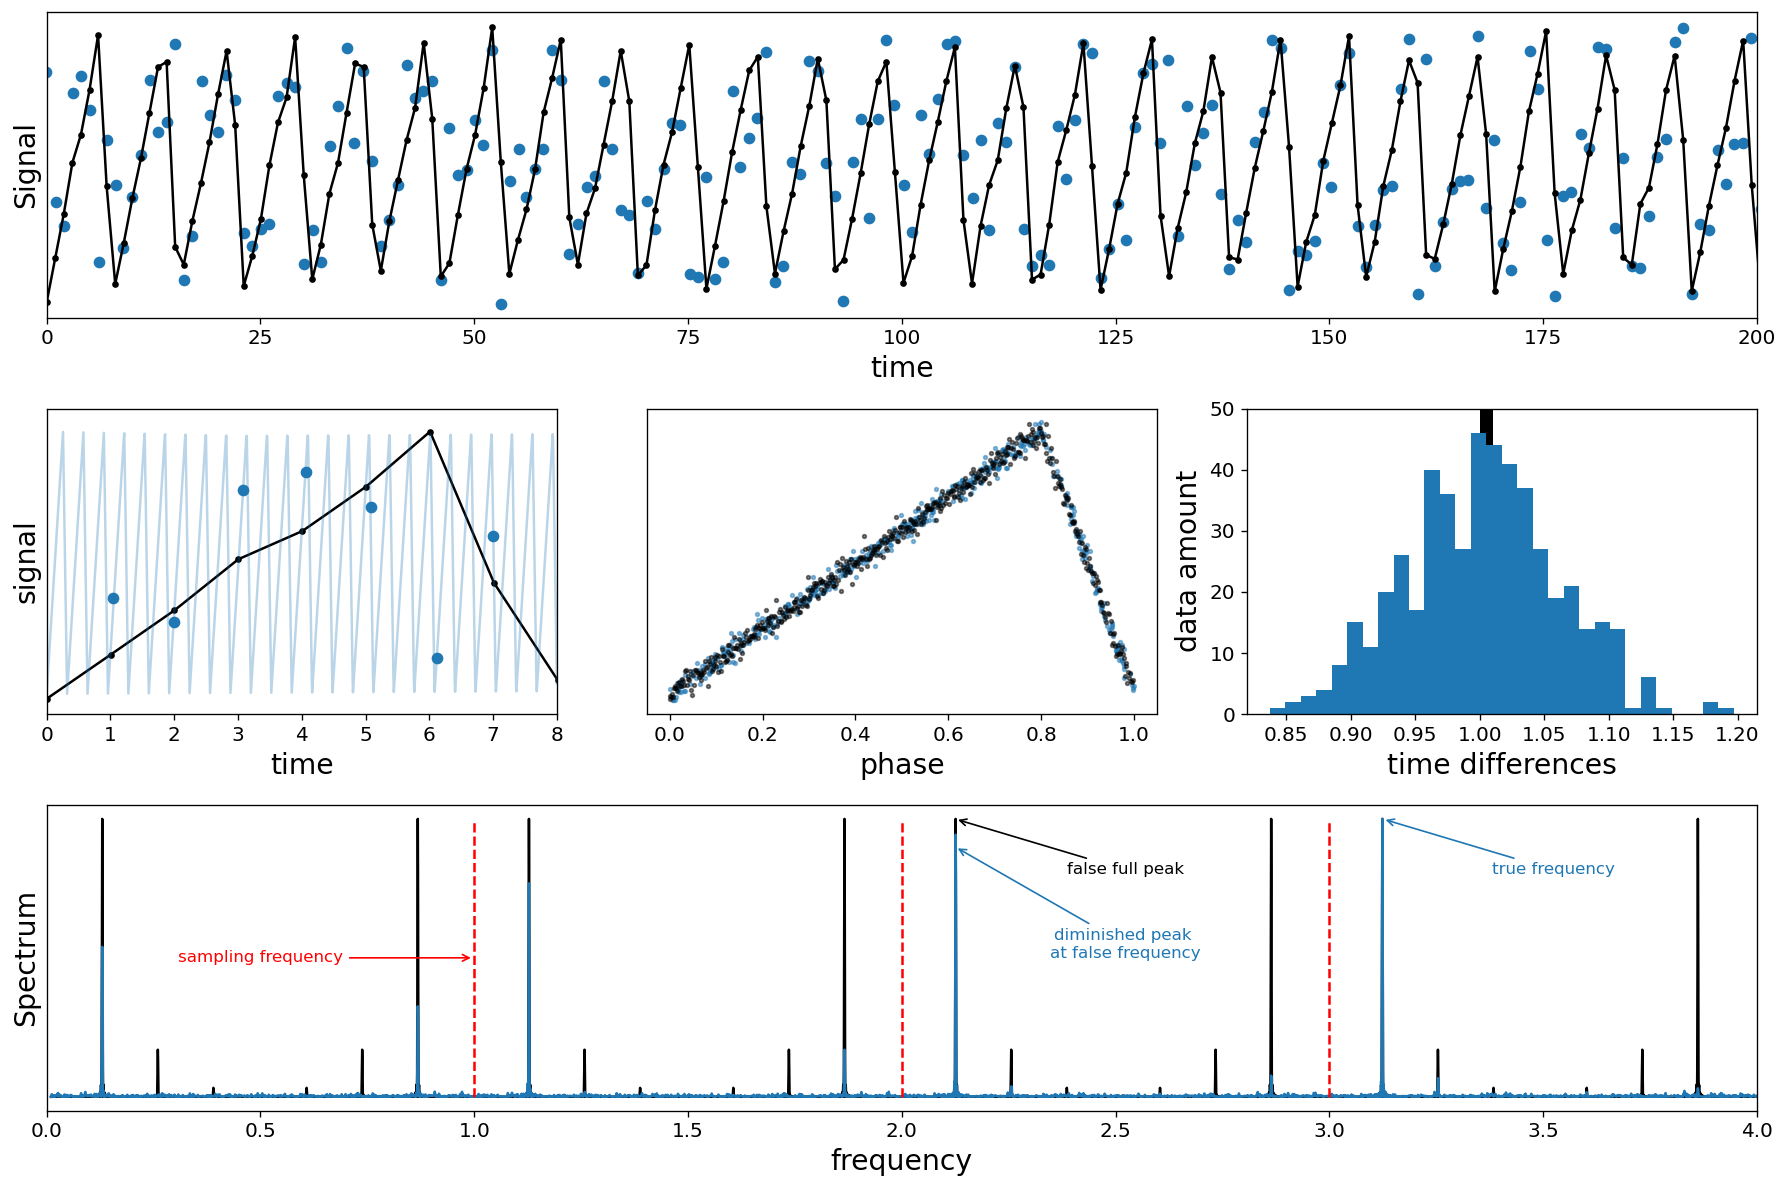

In [33]:
from scipy.signal import sawtooth

fig = plt.figure(figsize=(15,10))

ax = [
plt.subplot(3,3,(1,3)),
plt.subplot(3,3,(7,9)),
plt.subplot(3,3,4),
plt.subplot(3,3,5),
plt.subplot(3,3,6)
]

t = np.linspace(0,500,num=500)
t2 = t + np.random.normal(0,.04,size=len(t))
t2.sort()
freq = 3.124
m = sawtooth(freq*2*np.pi*t,0.8) + np.random.normal(0,0.05,size=len(t))
m2 = sawtooth(freq*2*np.pi*t2,0.8) + np.random.normal(0,0.05,size=len(t))

plt.sca(ax[0])
plt.plot(t,m,".-k")
plt.scatter(t2,m2)
plt.yticks([])
plt.ylabel("Signal")
plt.xlabel("time")
plt.xlim(0,200)


plt.sca(ax[2])
plt.plot(t,m,".-k")
t_dense = np.linspace(0,8,1500)
plt.plot(t_dense,sawtooth(freq*2*np.pi*t_dense,0.8),c='#1f77b4',alpha=0.3)
plt.scatter(t2,m2)
plt.xlim(0,8)
plt.xlabel("time")
plt.ylabel("signal")
plt.yticks([])

plt.sca(ax[3])
phi2 = phase(t2,freq)
plt.scatter(phi2,m2,s=5,alpha=0.5)
phi = phase(t,freq)
plt.scatter(phi,m,s=5,c='k',alpha=0.5)
plt.yticks([])
plt.xlabel("phase")

plt.sca(ax[4])
plt.hist(np.diff(t),[0.9,1.0,1.01],color='k');
plt.hist(np.diff(t2),30);
plt.ylim(0,50)
plt.ylabel("data amount")
plt.xlabel("time differences")

##### spectrum 

f_min = 0.01
f_max = 4.0
df = 0.0005
fs = np.arange(f_min,f_max,df)

F = fourier_incremental(t,m,f_min,f_max,df)
F /= F.max()
F2 = fourier_incremental(t2,m2,f_min,f_max,df)
F2 /= F2.max()

plt.sca(ax[1])
plt.plot(fs,F,c='k',alpha=1)
plt.plot(fs,F2)
plt.yticks([])
plt.ylabel("Spectrum")
plt.xlabel("frequency")
plt.xlim(0,4)

for i in range(1,4):
    plt.plot([i,i],[0,1],"--r")

plt.annotate(
    'true frequency',
    xy=(freq, 1),
    xycoords='data',
    xytext=(freq+0.4,0.8),
    textcoords='data',
    color='#1f77b4',
    horizontalalignment='center',
    arrowprops=dict(color='#1f77b4', arrowstyle="->")
)
plt.annotate(
    'diminished peak \nat false frequency',
    xy=(freq-1, 0.9),
    xycoords='data',
    xytext=(freq+0.4-1,0.5),
    textcoords='data',
    color='#1f77b4',
    horizontalalignment='center',
    arrowprops=dict(color='#1f77b4', arrowstyle="->")
)
plt.annotate(
    'false full peak',
    xy=(freq-1, 1),
    xycoords='data',
    xytext=(freq+0.4-1,0.8),
    textcoords='data',
    color='k',
    horizontalalignment='center',
    arrowprops=dict(color='k', arrowstyle="->")
)
plt.annotate(
    'sampling frequency',
    xy=(1, 0.5),
    xycoords='data',
    xytext=(0.5,0.5),
    textcoords='data',
    horizontalalignment='center',
    verticalalignment='center',
    color='r',
    arrowprops=dict(color='r', arrowstyle="->")
)





plt.tight_layout()

plt.savefig("../../text/img/uneven_advantage.pdf")